# Introduction

This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize.  The driver calls the mrJob packages and manages the iteration. 

## E Step: Given priors, mean vector and covariance matrix, calculate the probability of that each data point belongs to a class 

\begin{equation} 
p(\omega_k\vert x^{(i)},\theta) = 
\frac
{\phi_k\mathcal{N}(x^{(i)}\vert \mu_k, \sum_k)}
{\sum_{j=1}^K \phi_j \mathcal{N}(x^{(i)}\vert \mu_j, \sum_j)}~~~~~~~~~~~~~~~~~~~~~~~~(1)
\end{equation}

## M Step: Given probabilities, update priors, mean and covariance

\begin{equation}
\hat{\mu}_k = 
\frac{1}{n_k}
\sum_{i=1}^n p(\omega_k\vert x^{(i)},\theta) x^{(i)}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(2)
\end{equation}

\begin{equation}
\hat{\sum}_k = 
\frac{1}{n_k}
\sum_{i=1}^n p(\omega_k\vert x^{(i)},\theta) 
(x^{(i)}-\hat{\mu}_k)(x^{(i)}-\hat{\mu}_k)^T~~~~~(3)
\end{equation}


\begin{equation}
\hat{\phi}_k = 
\frac{n_k}{n}\text{  where  }
n_k = \sum_{i=1}^n p(\omega_k\vert x^{(i)},\theta)~~~~~~~~~~~~~~~~~(4)
\end{equation}

**where**  
$\theta$ represents the complete set of parameters for a mixture model with $K$ components.  
$\omega_k$ is the indicator variable representing whether the data point $x^{(i)}$ is emitted by the $k^{th}$ component.  
$n$ is the number of data points.  
$x^{(i)}$ means the $i^{th}$ data point.  
$\mu_k$ is the mean of the $k^{th}$ component (i.e. the center of each component).  
$\sum_k$ is the covariance matrix of the $k^{th}$ component.  
$\phi_k$ is the mixture weight, representing the probability that a randomly selected data point $x^{(i)}$ is emitted by the $k^{th}$ component.   
$K$ is the number of component (Gaussian model).  


In [4]:
%load_ext autoreload
%autoreload 2

# Data Generation

In [5]:
%matplotlib inline
import numpy as np
import pylab 
import json

# Generate data for 3 bivariate Gaussian models
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

# Randomize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

# Data Visualiazation

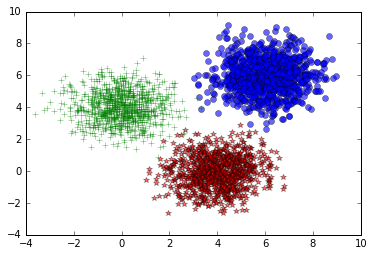

In [6]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red', alpha=0.6)
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue', alpha=0.6)
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green', alpha=0.6)
pylab.show()

# Initialization

Here suppose we know there are 3 components

In [7]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities (Gaussian models) in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2*k datapoints to generate the starting points of our k models
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and 
        #pull out k of them as starting point
        
        cent = [] # list of potential starting points.
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj  # Why yield again?
            
        #assert len(cent) == 2*self.options.k, \
        #    "There should be 2*k potential starting points.  But we got " + str(len(cent))
        
        # Randomly pick k starting points from cent[]
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            cent2.append(cent[i])       
        
            
        #use the covariance of the selected centers as the starting guess for covariances

        #first, calculate mean of centers
        mean = array(cent2[0]) # numpy.array
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k) # the average "center"
                       
        #then accumulate the deviations
        cov = zeros((len(mean),len(mean)),dtype=float)
        for x in cent2:
            xmm = array(x) - mean
            for i in range(len(mean)):
                cov[i,i] = cov[i,i] + xmm[i]*xmm[i]
                
        cov = cov/(float(self.options.k))
        covInv = linalg.inv(cov)
        
        cov_1 = [covInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
       
        phi = zeros(self.options.k,dtype=float)        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), cent2, cov_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


# Iteration

**Mapper** – each mapper needs k (number of components) vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  

    Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [11]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    # P_1 is the covariance matrix of the gaussian model
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()        
        inputList = json.loads(inputJson)
        
        self.phi = array(inputList[0] ) #prior class probabilities (i.e. mixture weights)
        self.means = array(inputList[1])#current means list
        self.cov_1 = array(inputList[2])#inverse covariance matrices for w, calc.
        
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        # Goals:
        # - This is the E-Step for one data point (x).
        # - It generates the partial components for the M steps (eq 2-4)
        #   Those component are partial because they're about one particular data point x        
        
        # A data point.  It's the x^(i) in equations 1-4
        x = array(json.loads(val))         
        
        #######################################################
        # The E-Step for this data point.
        wtVect = zeros_like(self.phi)
        for k in range(self.options.k):
            # this is the numerator (for one k) in equation (1)
            wtVect[k] = self.phi[k]*gauss(x,self.means[k],self.cov_1[k])
            
        wtSum = sum(wtVect) # this is the denominator in equation (1)
        
        # See equation (1)
        # wtVect is a list, each item is the value on the LHS of equation (1)
        # So there are k items in wtVect.
        wtVect = wtVect/wtSum
        
        #######################################################
        # Generate the partial components for the M-Step for this data point x
        
        # See equation (4)        
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        
        #accumulate weights for phi est
        self.new_phi += wtVect # see the LHS of equation (4)
        
        for k in range(self.options.k):
            # See equation (2)
            #accumulate weighted x's for mean calc
            self.new_means[k] += wtVect[k]*x
            
            # See equation (3)
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[k]
            covInc = zeros_like(self.new_cov[k])
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[k] = self.new_cov[k] + wtVect[k]*covInc     

        
    def mapper_final(self):
        
        out = [self.count, (self.new_phi).tolist(), 
               (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        
        # Emit out all the components (for E and M steps) contributed by all the data 
        # points (x's) read by this mapper instance.
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        # Goals: 
        # - Finish the M-step by gathering the partial sums from all the mappers, and 
        #   calculate those values in eq 2-4
        
        # xs is a list of paritial stats, including:
        # - count of data points
        # - phi (mixture weight) of each component
        # - mean (i.e. center) of each component
        # - covariance of each component
        #Each stats is k-length array, storing info for k components
        
        first = True        
        for val in xs:
            temp = json.loads(val)
            if first:
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0] # totCount = n, the total # of data points
                totPhi = array(temp[1]) # totPhi is the n_k in equations 2-4.
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else:
                #cumulative sum of four arrays
                totCount += temp[0]
                totPhi += array(temp[1])
                totMeans += array(temp[2])
                totCov += array(temp[3])
                
        #finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount # see equation (4)
        
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        for k in range(self.options.k):
            newMeans[k,:] = totMeans[k,:]/totPhi[k]
            tempCov = totCov[k,:,:]/totPhi[k]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[k,:,:] = linalg.inv(tempCov)
        
        # Output the result for equation 2-4
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

In [9]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath, 
               '--pathName', '/Users/patrickng/Documents/mids/w261/assignments/wk6/', 
               '-r', 'inline',
                '--no-strict-protocols'])
with mrJob.make_runner() as runner:
    runner.run()

Iteration0
[[5.803787446294021, 5.471195850925436], [5.473003517449657, 7.0355317411007], [2.5188379288992553, -0.7987091986790891]]


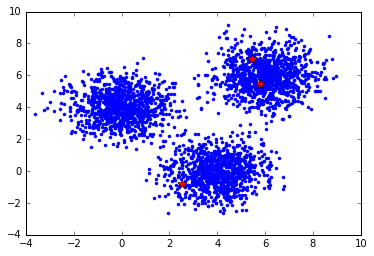

Iteration1
[[5.629082173206266, 4.2914285644510715], [5.5466925056038585, 4.984073833185278], [1.5125679990113925, 2.276503529684732]]


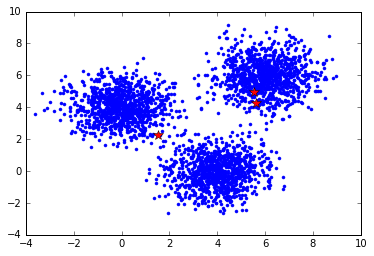

Iteration2
[[5.610228288754801, 4.181106803690994], [5.595226837684674, 4.675887762600234], [1.3886348490600782, 2.3918803203115675]]


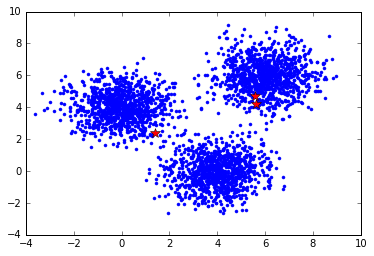

Iteration3
[[5.61214617711484, 4.17203144714181], [5.6282318749486375, 4.862182121854939], [1.4377607508101855, 2.360803771588834]]


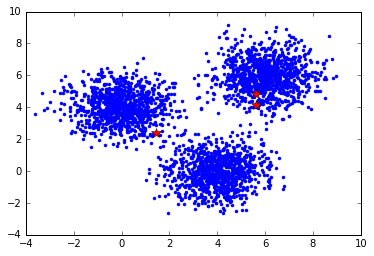

Iteration4
[[5.602841555814279, 4.1051627500247525], [5.6813439912551065, 5.123784616233454], [1.4800081650429828, 2.3289919727899613]]


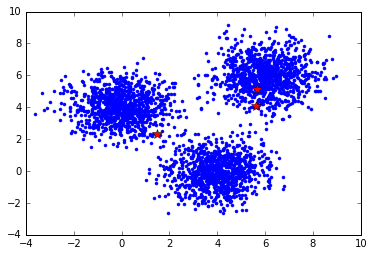

Iteration5
[[5.576321289242915, 3.9621083876050225], [5.758587279971922, 5.461985278311909], [1.5188780593234816, 2.299338347010261]]


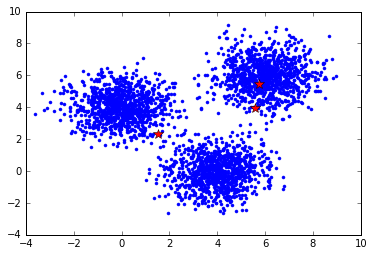

Iteration6
[[5.516872583279088, 3.6902435896623356], [5.848730819559848, 5.8226494212942566], [1.5490617711053571, 2.282272796534938]]


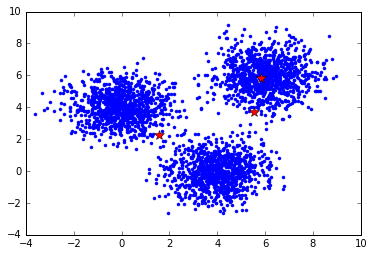

Iteration7
[[5.4004372623634485, 3.2261269382074635], [5.916882156749005, 6.023421806231123], [1.552203792087764, 2.294048661991422]]


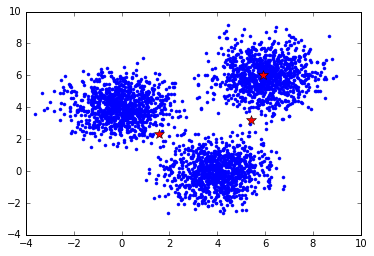

Iteration8
[[5.24164432695226, 2.655974708423373], [5.954517247203824, 6.06376968567759], [1.5305215209361565, 2.328922134342155]]


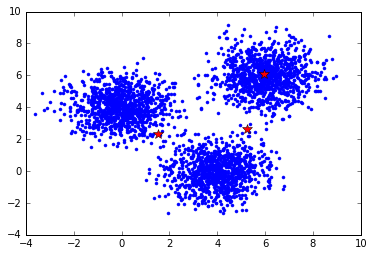

Iteration9
[[5.097595002844625, 2.1637719651568696], [5.973489517221753, 6.073370912338886], [1.502747793362495, 2.3682297319754433]]


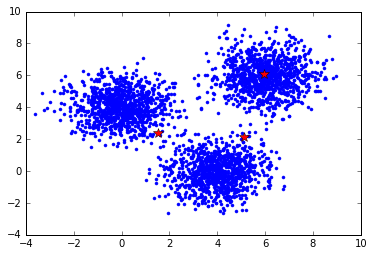

Iteration10
[[4.97286920059214, 1.7515494910519567], [5.983318660520719, 6.077113109747387], [1.4715725154366879, 2.4071874895427516]]


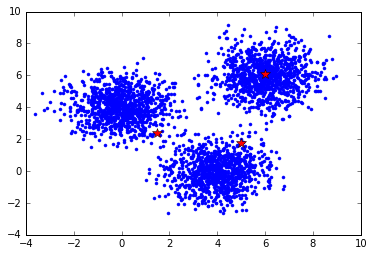

Iteration11
[[4.854598135507306, 1.37523784919164], [5.990142373090591, 6.078649601294653], [1.4349524517235468, 2.4489643910285075]]


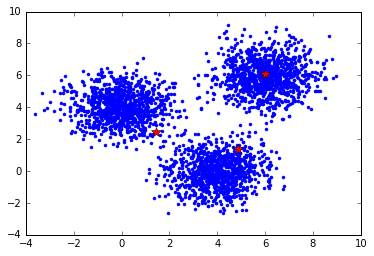

Iteration12
[[4.7321170728062425, 1.0046681896120866], [5.996676238094773, 6.0771546211265495], [1.3891431500004257, 2.4985245808278664]]


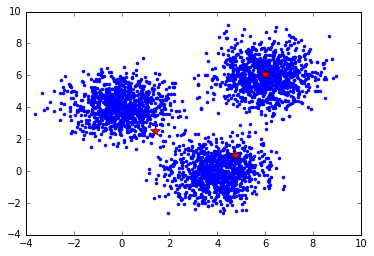

Iteration13
[[4.599882054377512, 0.6321169759082821], [6.003268932849507, 6.067761474680194], [1.3272164143651177, 2.563639901728624]]


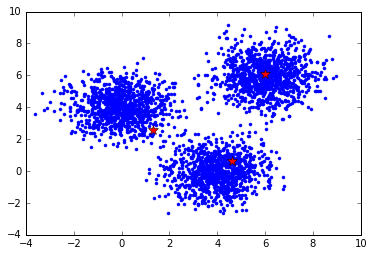

Iteration14
[[4.462954764851451, 0.28456934480017926], [6.008570075428634, 6.04405004067205], [1.2379505699354962, 2.656612145676508]]


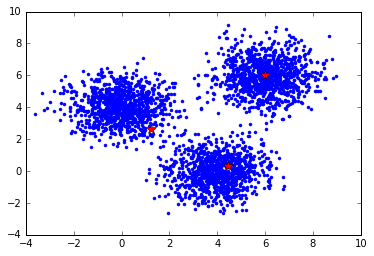

Iteration15
[[4.340052963156963, 0.01938538924212061], [6.011648227619936, 6.008329263554322], [1.1085185751664461, 2.7924740266546833]]


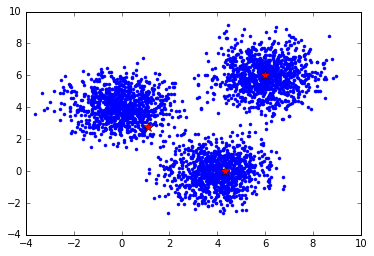

Iteration16
[[4.254830422368741, -0.11882687414553438], [6.013184792124895, 5.978211128388551], [0.9379635420421052, 2.9756433771056274]]


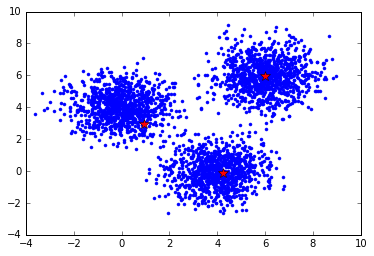

Iteration17
[[4.207025952124001, -0.16714437669433066], [6.013431346507244, 5.965539340130007], [0.7512702544098978, 3.1817274551793764]]


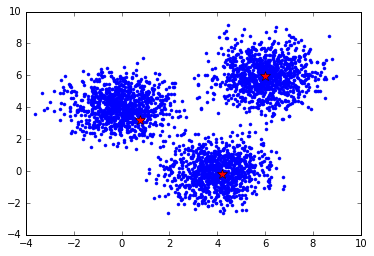

Iteration18
[[4.173243339250165, -0.18176960086043498], [6.013435843624993, 5.961698991551399], [0.5616632864371542, 3.3917650856297596]]


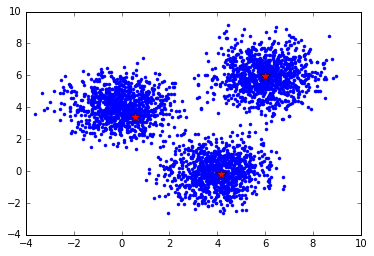

Iteration19
[[4.135704182464909, -0.1731754058735652], [6.013556422952805, 5.960427673966019], [0.37228800617989044, 3.599295696119163]]


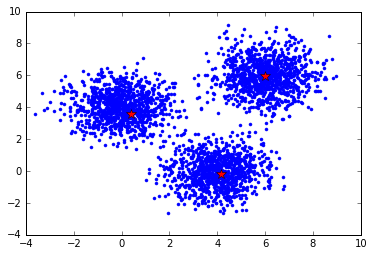

Iteration20
[[4.0859898686897935, -0.1422710595681932], [6.013494610783472, 5.959763119102549], [0.20230053794351238, 3.7850457411543807]]


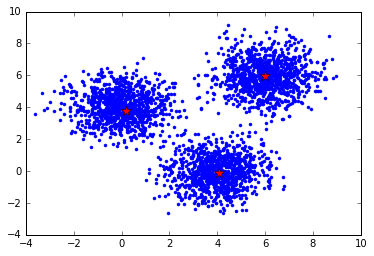

Iteration21
[[4.0335727266339845, -0.10341448781612693], [6.013062999353346, 5.959182481910274], [0.0761710305267011, 3.924890471065907]]


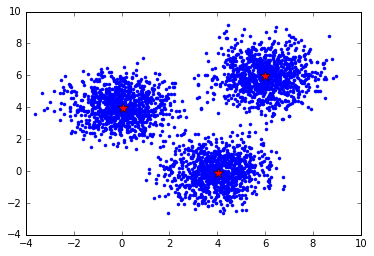

Iteration22
[[3.9987548111237783, -0.07513434405300466], [6.012121985884538, 5.958446974565295], [0.011066517765705787, 3.996777628318786]]


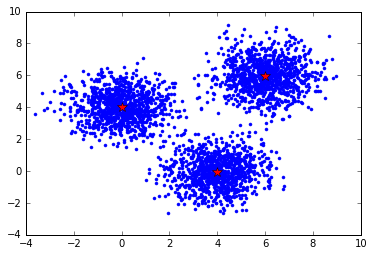

Iteration23
[[3.985436957544312, -0.06192059621296726], [6.010992443354865, 5.957689327474374], [-0.0108101764916797, 4.017957821618337]]


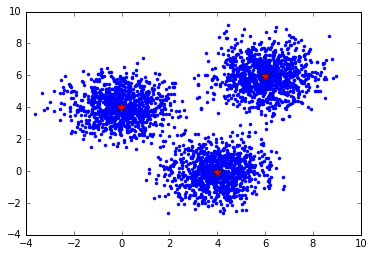

Iteration24
[[3.9812805710257124, -0.0572017571272661], [6.010306379780313, 5.957297032803205], [-0.017295517931432372, 4.023204149581194]]


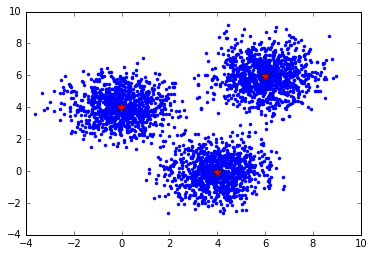

In [10]:
#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    
    #parse old centroid values
    oldParam = json.loads(paramJson)
    
    #run one iteration
    oldMeans = oldParam[1]
    
    mrJob2 = MrGMixEm(args=[filePath,
                  '--pathName', '/Users/patrickng/Documents/mids/w261/assignments/wk6/', 
                   '--no-strict-protocols'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
    plot_iteration(oldMeans)
    
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)